In [301]:
import os
import pickle
import joblib
import zipfile
import numpy as np
import pandas as pd
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split


# Downloading the data

In [302]:
TITANIC_ROOT = os.path.join("datasets", "databases")
MODELS_ROOT = os.path.join("models", "titanic")
os.makedirs(TITANIC_ROOT, exist_ok=True)
os.makedirs(MODELS_ROOT, exist_ok=True)
os.makedirs("graphs", exist_ok=True)

!kaggle competitions download -c titanic -p {TITANIC_ROOT}

titanic_zip = os.path.join(TITANIC_ROOT, "titanic.zip")
with zipfile.ZipFile(titanic_zip, 'r') as zip_ref:
    zip_ref.extractall(TITANIC_ROOT)

os.remove(titanic_zip)

print(f"Files in directory: {os.listdir(TITANIC_ROOT)}")

Files in directory: ['gender_submission.csv', 'test.csv', 'train.csv']


# Preprocessing Class

In [303]:
from abc import ABC, abstractmethod

class Preprocessing(ABC):
    def __init__(self, titanic_path=TITANIC_ROOT):
        train_csv_path = os.path.join(titanic_path, "train.csv")
        test_csv_path = os.path.join(titanic_path, "test.csv")
        self.train = pd.read_csv(train_csv_path)
        self.test = pd.read_csv(test_csv_path)
        self.deleting_columns()
        self.numeric_columns_train = self.train.select_dtypes(include=['int64', 'float64'])
        self.categorical_columns_train = self.train.select_dtypes(exclude=['int64', 'float64'])
        self.numeric_columns_test = self.test.select_dtypes(include=['int64', 'float64'])
        self.categorical_columns_test = self.test.select_dtypes(exclude=['int64', 'float64'])

    def deleting_columns(self):
        # Dropping the PassengerId and Name columns from train dataset and test dataset as well
        self.train.drop(columns=["PassengerId", "Name"], inplace=True)
        self.test.drop(columns=["PassengerId", "Name"], inplace=True)

        # Verifying if the PassengerId and Name columns from train and test datasets was dropped correctly
        columns_to_check = ["PassengerId", "Name"]
        for col in columns_to_check:
            status = "was dropped  correctly" if col not in self.train.columns or col not in self.test.columns else "was not dropped"
            print(f"Deleting column {col}: {status}")

    @abstractmethod
    def inconsistent_data(self):
        pass

    @abstractmethod
    def missing_data(self):
        pass


# Train Dataset

In [304]:
class TrainPreprocessing(Preprocessing):
    def __init__(self):
        super().__init__()
        self.X = self.train.drop(columns="Survived")
        self.y = self.train["Survived"]
        self.X_train = None
        self.X_test = None
        self.y_train = None
        self.y_test = None
        self.X_val = None
        self.y_val = None


    # Verifying inconsistent values
    def inconsistent_data(self):
        for column in self.numeric_columns_train.columns:
            inconsistent_values = self.train.loc[self.train[column] < 0]
            if inconsistent_values.empty:
                print(f"Column {column} has no inconsistent values")
            else:
                print(f"Column {column} has inconsistent values")

        return self.train

    # Verifying missing data
    def missing_data(self):
        print(self.train.isnull().sum())

        # Replacing the missing values in numerical columns with the mean
        self.train[self.numeric_columns_train.columns] = self.train[self.numeric_columns_train.columns].apply(lambda column: column.fillna(column.mean()))
        # Replacing the missing data in categorical columns as 'Unknown'
        self.train[self.categorical_columns_train.columns] = self.train[self.categorical_columns_train.columns].fillna("Unknown")

        return self.train

    def histogram_graphs(self):
        self.train.hist(bins=50, figsize=(20, 15), color="red")
        plt.tight_layout()
        plt.savefig(os.path.join("graphs", "histogram.png"))
        plt.show()

    def correlation_matrix(self):
        correlation_matrix = self.numeric_columns_train.corr()
        survived_correlation = correlation_matrix["Survived"].sort_values(ascending=False)
        print(survived_correlation)

        plt.figure(figsize = (10, 8))
        survived_correlation.plot(kind="bar", color="red")
        plt.xlabel('Features')
        plt.ylabel('Correlation')
        plt.savefig(os.path.join("graphs", "correlation_matrix.png"))
        plt.show()

    def dynamic_graph(self):
        graph = px.scatter_matrix(self.train, dimensions=["Survived", "Fare", "Pclass"], color="Survived")
        graph.show()

    def boxplots_graphs(self):
        for feature in self.numeric_columns_train.columns:
            graph = px.box(self.train, y=feature)
            graph.show()

    def removing_outliers(self):
        outliers_columns = ["Fare", "SibSp", "Parch"]
        for column in outliers_columns:
            q1 = self.train[column].quantile(0.25)
            q3 = self.train[column].quantile(0.75)
            iqr = q3 - q1
            lower_bound = q1 - 1.5 * iqr
            upper_bound = q3 + 1.5 * iqr
            self.train = self.train[(self.train[column] >= lower_bound) & (self.train[column] <= upper_bound)]

    def splitting_data(self):
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(self.X, self.y, test_size=0.3,random_state=42)

        self.X_train, self.X_val, self.y_train, self.y_val = train_test_split(self.X_train, self.y_train, test_size=0.2, random_state=42)

        split_datasets_path = os.path.join("datasets", "split_datasets")
        os.makedirs(split_datasets_path, exist_ok=True)

        # Saving the datasets
        try:
            with open(os.path.join(split_datasets_path, "split_datasets.pkl"), "wb") as file:
                pickle.dump([self.X_train, self.X_val, self.X_test, self.y_train, self.y_val, self.y_test], file)
        except Exception as e:
            print(f"Could not save split datasets: {e}")

    def one_hot_encoder(self):
        #Selecting categorical features
        selected_features = ["Sex", "Embarked"]
        # Initializing the OneHotEncoder (dropping first to avoid multicollinearity)
        encoder = OneHotEncoder(sparse_output=False, drop="first")

        encoded_data = encoder.fit_transform(self.X_train[selected_features])
        encoded_data_df = pd.DataFrame(encoded_data, columns=encoder.get_feature_names_out(selected_features), index=self.X_train.index)

        # Replacing original categorical columns with encoded ones
        self.X_train = pd.concat([self.X_train.drop(columns=selected_features), encoded_data_df], axis=1)

        # Updating numeric and categorical columns
        self.numeric_columns_train = self.X_train.select_dtypes(include=['int64', 'float64'])
        self.categorical_columns_train = self.X_train.select_dtypes(exclude=['int64', 'float64'])

        encoder_path = os.path.join(MODELS_ROOT, "one_hot_encoder.pkl")
        try:
            joblib.dump(encoder, encoder_path)
            print(f"Encoder saved at: {encoder_path}")
        except Exception as e:
            print(f"Error saving encoder: {e}")


In [305]:
preprocessing = TrainPreprocessing()
preprocessing.train.head(10)

Deleting column PassengerId: was dropped  correctly
Deleting column Name: was dropped  correctly


,Survived,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,0,3,male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,1,1,female,38.0,1,0,PC 17599,71.2833,C85,C
2,1,3,female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,1,1,female,35.0,1,0,113803,53.1000,C123,S
4,0,3,male,35.0,0,0,373450,8.0500,NaN,S
5,0,3,male,NaN,0,0,330877,8.4583,NaN,Q
6,0,1,male,54.0,0,0,17463,51.8625,E46,S
7,0,3,male,2.0,3,1,349909,21.0750,NaN,S
8,1,3,female,27.0,0,2,347742,11.1333,NaN,S
9,1,2,female,14.0,1,0,237736,30.0708,NaN,C


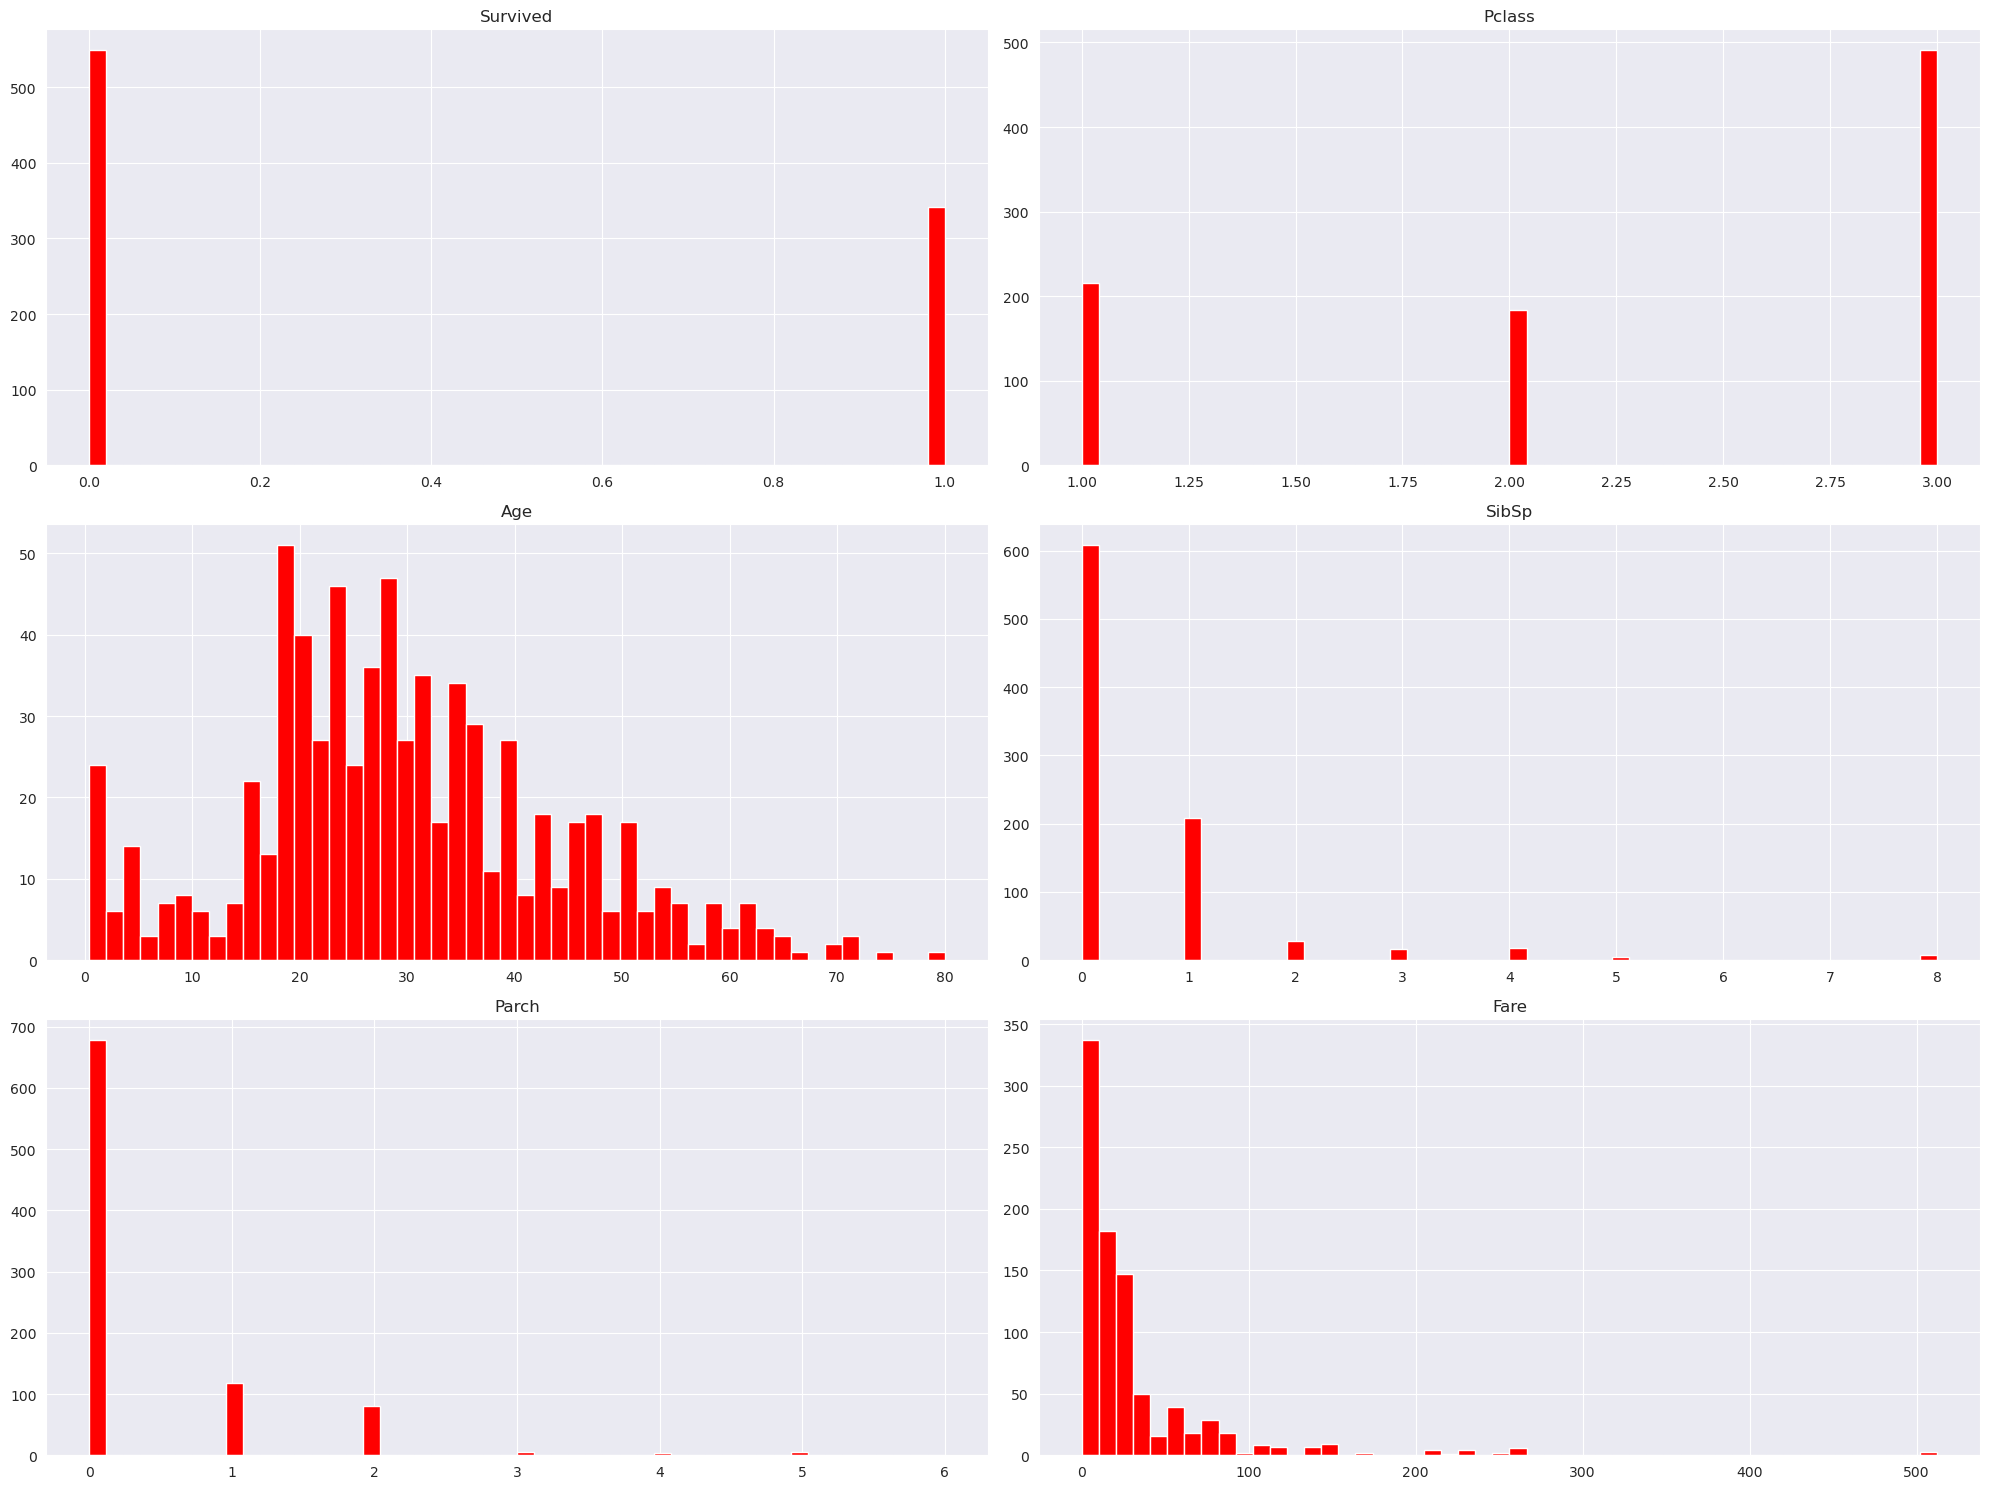

In [306]:
preprocessing.histogram_graphs()

In [307]:
preprocessing.inconsistent_data()

Column Survived has no inconsistent values
Column Pclass has no inconsistent values
Column Age has no inconsistent values
Column SibSp has no inconsistent values
Column Parch has no inconsistent values
Column Fare has no inconsistent values


,Survived,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,0,3,male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,1,1,female,38.0,1,0,PC 17599,71.2833,C85,C
2,1,3,female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,1,1,female,35.0,1,0,113803,53.1000,C123,S
4,0,3,male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...
886,0,2,male,27.0,0,0,211536,13.0000,NaN,S
887,1,1,female,19.0,0,0,112053,30.0000,B42,S
888,0,3,female,NaN,1,2,W./C. 6607,23.4500,NaN,S
889,1,1,male,26.0,0,0,111369,30.0000,C148,C


In [308]:
preprocessing.missing_data()

Survived      0
Pclass        0
Sex           0
Age         177
SibSp         0
Parch         0
Ticket        0
Fare          0
Cabin       687
Embarked      2
dtype: int64


,Survived,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,0,3,male,22.000000,1,0,A/5 21171,7.2500,Unknown,S
1,1,1,female,38.000000,1,0,PC 17599,71.2833,C85,C
2,1,3,female,26.000000,0,0,STON/O2. 3101282,7.9250,Unknown,S
3,1,1,female,35.000000,1,0,113803,53.1000,C123,S
4,0,3,male,35.000000,0,0,373450,8.0500,Unknown,S
...,...,...,...,...,...,...,...,...,...,...
886,0,2,male,27.000000,0,0,211536,13.0000,Unknown,S
887,1,1,female,19.000000,0,0,112053,30.0000,B42,S
888,0,3,female,29.699118,1,2,W./C. 6607,23.4500,Unknown,S
889,1,1,male,26.000000,0,0,111369,30.0000,C148,C


Survived    1.000000
Fare        0.257307
Parch       0.081629
SibSp      -0.035322
Age        -0.077221
Pclass     -0.338481
Name: Survived, dtype: float64


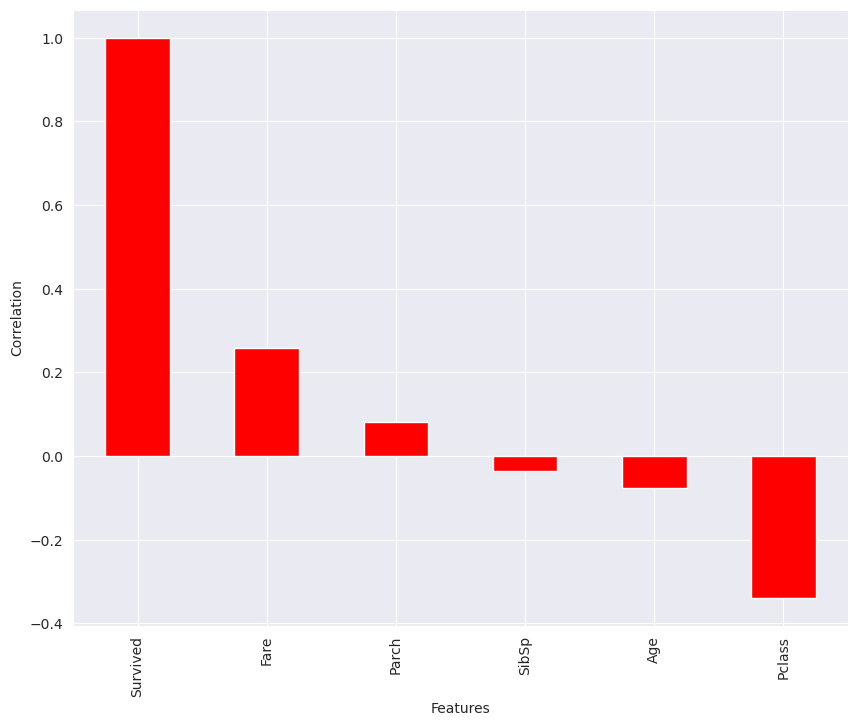

In [309]:
preprocessing.correlation_matrix()

In [310]:
preprocessing.dynamic_graph()

In [311]:
preprocessing.boxplots_graphs()

In [312]:
preprocessing.removing_outliers()

In [313]:
preprocessing.train["Sex"].value_counts()

Sex
male      460
female    147
Name: count, dtype: int64

In [314]:
preprocessing.splitting_data()

In [315]:
preprocessing.one_hot_encoder()

Encoder saved at: models/titanic/one_hot_encoder.pkl


# Test Dataset

In [316]:
class TestPreprocessing(Preprocessing):
    # Verifying inconsistent values
    def inconsistent_data(self):
        for column in self.numeric_columns_test.columns:
            inconsistent_values = self.test.loc[self.test[column] < 0]
            if inconsistent_values.empty:
                print(f"Column {column} has no inconsistent values")
            else:
                print(f"Column {column} has inconsistent values")

        return self.test

    # Verifying missing data
    def missing_data(self):
        print(self.test.isnull().sum())

        # Replacing the missing values in numerical columns with the mean
        self.test[self.numeric_columns_test.columns] = self.train[self.numeric_columns_test.columns].apply(lambda column: column.fillna(column.mean()))
        # Replacing the missing data in categorical columns as 'Unknown'
        self.test[self.categorical_columns_test.columns] = self.train[self.categorical_columns_test.columns].fillna("Unknown")

        return self.test


In [317]:
test_preprocessing = TestPreprocessing()
test_preprocessing.test.head(10)

Deleting column PassengerId: was dropped  correctly
Deleting column Name: was dropped  correctly


,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,3,male,34.5,0,0,330911,7.8292,NaN,Q
1,3,female,47.0,1,0,363272,7.0000,NaN,S
2,2,male,62.0,0,0,240276,9.6875,NaN,Q
3,3,male,27.0,0,0,315154,8.6625,NaN,S
4,3,female,22.0,1,1,3101298,12.2875,NaN,S
5,3,male,14.0,0,0,7538,9.2250,NaN,S
6,3,female,30.0,0,0,330972,7.6292,NaN,Q
7,2,male,26.0,1,1,248738,29.0000,NaN,S
8,3,female,18.0,0,0,2657,7.2292,NaN,C
9,3,male,21.0,2,0,A/4 48871,24.1500,NaN,S
